In [ ]:
from pathlib import Path
import random
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

from ..src.data_pipeline import random_test_patches_mask


In [2]:
DATA_PATH      = Path("../data/processed/oxygen_00_train_data.parquet")
TARGET         = "oxygen_00"
TEST_BBOX      = {                       # Morze Śródziemne
    "lat_min": 30.0, "lat_max": 46.0,
    "lon_min": -6.0, "lon_max": 36.0
}
SEED           = 42
N_JOBS         = -1
SUB_FRAC       = 0.40  # bo RAM sie konczy xD 100% train_df zabiera 25GB RAMu, mozna inne podejscia spróbować


In [3]:
random.seed(SEED)
np.random.seed(SEED)

df = pd.read_parquet(DATA_PATH)

In [4]:

deg2rad = np.pi / 180.0
df["sin_lat"]   = np.sin(df["lat"] * deg2rad)
df["cos_lat"]   = np.cos(df["lat"] * deg2rad)
df["sin_lon"]   = np.sin(df["lon"] * deg2rad)
df["cos_lon"]   = np.cos(df["lon"] * deg2rad)
df["norm_depth"] = df["depth"] / df["depth"].max()


In [5]:
cols = ["temperature_00", "salinity_00", "nitrate_00", "phosphate_00"]

In [6]:
print(f"Data shape: {df.shape}")
df = df.dropna(subset=cols).reset_index(drop=True)
print(f"Data shape after dropping NaNs: {df.shape}")

Data shape: (1594124, 13)
Data shape after dropping NaNs: (609912, 13)


In [33]:
FEATURES = [
    "temperature_00", "nitrate_00", "salinity_00", "phosphate_00",
    "sin_lat", "cos_lat", "sin_lon", "cos_lon", "norm_depth"
]

test_mask = random_test_patches_mask(df, grid_size=(8, 8), n_patches=5, seed=345345)

train_df = df.loc[~test_mask].reset_index(drop=True)
test_df  = df.loc[test_mask].reset_index(drop=True)

train_df   = train_df.sample(frac=SUB_FRAC, random_state=SEED).reset_index(drop=True)

print(f"Train samples: {len(train_df):,d}")
print(f"Test  samples: {len(test_df):,d}")

Train samples: 222,731
Test  samples: 53,084


C:\Users\dosti\AppData\Local\Temp\ipykernel_19808\2115757900.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
d:\Coding\Venvs\DataScience\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


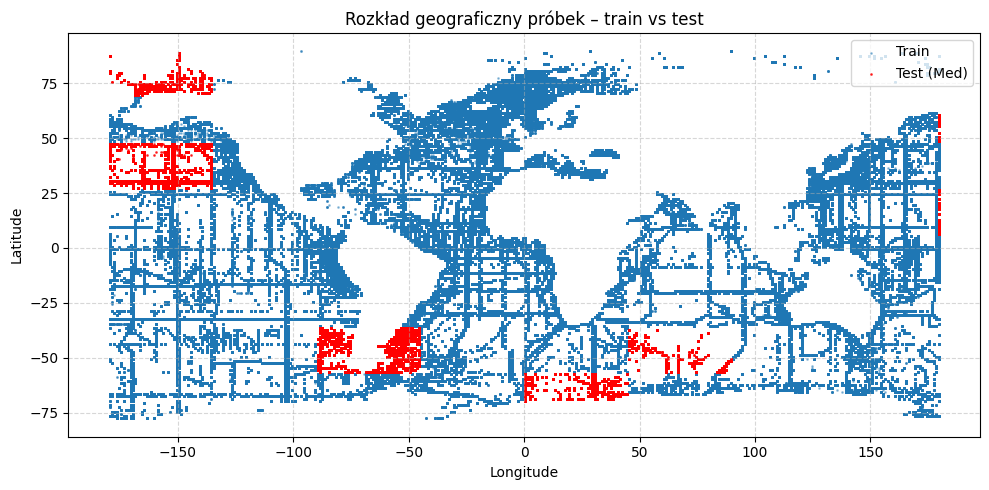

In [34]:
plt.figure(figsize=(10,5))
plt.scatter(df[~test_mask]["lon"], df[~test_mask]["lat"], s=1, label="Train", alpha=0.4)
plt.scatter(df[test_mask]["lon"], df[test_mask]["lat"], s=1, label="Test (Med)", alpha=0.7, color="red")
plt.legend()
plt.title("Rozkład geograficzny próbek – train vs test")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [35]:

X_train, y_train = train_df[FEATURES].values, train_df[TARGET].values
X_test,  y_test  = test_df[FEATURES].values,  test_df[TARGET].values

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

In [36]:

def evaluate(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name:<18} MSE={mse:.4f} RMSE={rmse:.4f} MAE={mae:.4f}  R2={r2:.4f}")

In [37]:
rf_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=SEED)
)

rf_pipe.fit(X_train, y_train)
pred_rf = rf_pipe.predict(X_test)
evaluate("RandomForest", y_test, pred_rf)

RandomForest       MSE=151.9239 RMSE=12.3257 MAE=8.2806  R2=0.9799


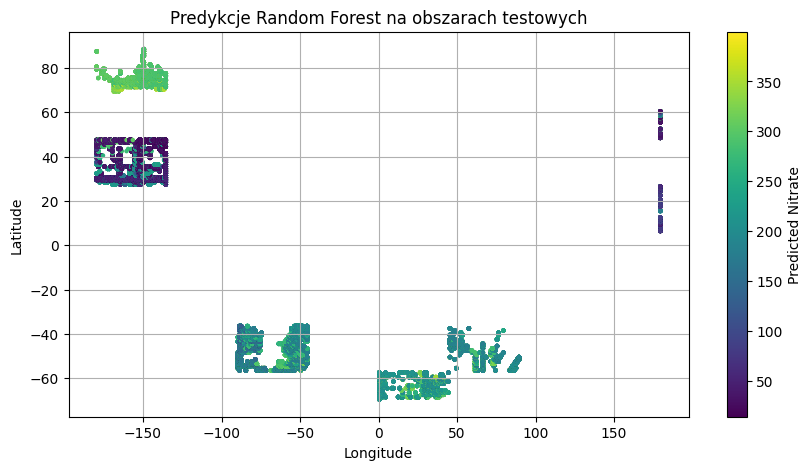

In [38]:
df_test = df[test_mask].copy()
df_test["prediction"] = pred_rf

plt.figure(figsize=(10, 5))
sc = plt.scatter(df_test["lon"], df_test["lat"], c=df_test["prediction"], cmap="viridis", s=5)
plt.colorbar(sc, label="Predicted Nitrate")
plt.title("Predykcje Random Forest na obszarach testowych")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

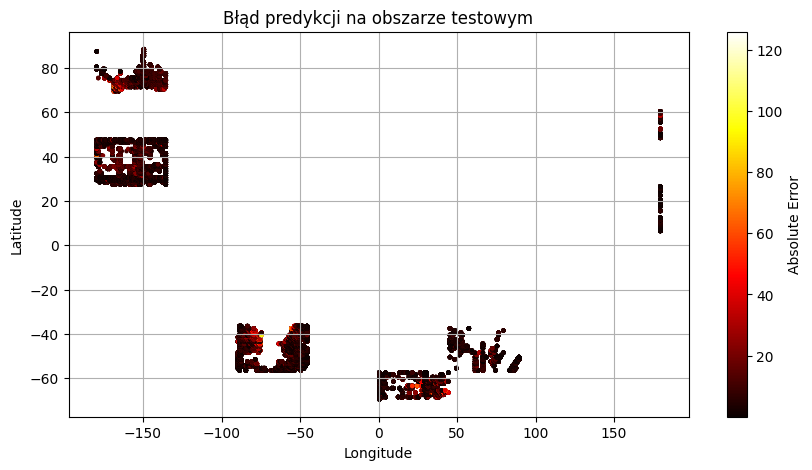

In [39]:
df_test["true"] = y_test
df_test["error"] = np.abs(df_test["true"] - df_test["prediction"])

plt.figure(figsize=(10, 5))
sc = plt.scatter(df_test["lon"], df_test["lat"], c=df_test["error"], cmap="hot", s=5)
plt.colorbar(sc, label="Absolute Error")
plt.title("Błąd predykcji na obszarze testowym")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [23]:

xgb = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    reg_lambda=1.0,
    device='cuda',
    n_jobs=N_JOBS,
    random_state=SEED,
)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
evaluate("XGBoost", y_test, pred_xgb)

XGBoost            MSE=369.5936 RMSE=19.2248 MAE=13.3007  R2=0.9312


d:\Coding\Venvs\DataScience\lib\site-packages\xgboost\core.py:729: UserWarning: [17:01:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [24]:

train_pts = train_df[["lat", "lon", "depth"]].values
test_pts  = test_df[["lat", "lon", "depth"]].values
val_train = y_train

pred_lin = griddata(train_pts, val_train, test_pts, method="linear")
# fallback na najbliższy sąsiad tam, gdzie linear == NaN
nan_mask = np.isnan(pred_lin)
if nan_mask.any():
    pred_nn = griddata(train_pts, val_train, test_pts[nan_mask], method="nearest")
    pred_lin[nan_mask] = pred_nn
evaluate("Linear interp 3D", y_test, pred_lin)

Linear interp 3D   MSE=1191.6994 RMSE=34.5210 MAE=22.8665  R2=0.7781


In [25]:

out = test_df[["lat", "lon", "depth"]].copy()
out["nitrate_true"] = y_test
out["rf_pred"]       = pred_rf
out["xgb_pred"]      = pred_xgb
out["interp_pred"]   = pred_lin
out.to_csv("../results/baseline_predictions_nitrate.csv", index=False)
print(">> Wyniki zapisane do ../results/baseline_predictions_nitrate.csv")


>> Wyniki zapisane do ../results/baseline_predictions_nitrate.csv
